**Подключение библиотек и скриптов**

In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv
/kaggle/input/real-estate-price-prediction-moscow/train.csv
/kaggle/input/real-estate-price-prediction-moscow/test.csv


In [23]:
import pandas as pd
import numpy as np
import sklearn as skl
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RepeatedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from datetime import datetime
import xgboost as xgb
import random
from sklearn.model_selection import cross_val_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [24]:
import seaborn as sns

In [25]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
matplotlib.rcParams.update({'font.size': 14})

In [27]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Пути к директориям и файлам

In [28]:
TRAIN_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/test.csv'

**Загрузим и посмотрим на датасет.** 

In [29]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855


In [30]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

**В данных есть пропуски (LifeSquare и Healthcare_1). Так же признак Id, в принципе, бесполезен, т.к. уникален для каждого объекта. Целевая переменная - Price.** 

**Загрузим и посмотрим на тестовый датасет**

In [31]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B


In [32]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

**В тестовом датасете нет целевой переменной. Так же присутствуют пропуски данных.**

In [33]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


**В тестовом датасете нет целевой переменной - тогда количество признаков на 1 меньше чем в трейне. Проверим это.**

In [34]:
train_df.shape[1] - 1 == test_df.shape[1]

True

### Приведение типов и уменьшение занимаемой памяти

**Посмотрим на типы данных тренировочного датасета**

In [35]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

**Процедура анализа данных и изменение их типа с целью уменьшения занимаемой памяти.**

In [36]:
def reduce_mem_usage(train_df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = train_df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in train_df.columns:
        col_type = train_df[col].dtype
        
        if col_type != object:
            c_min = train_df[col].min()
            c_max = train_df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    train_df[col] = train_df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    train_df[col] = train_df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    train_df[col] = train_df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    train_df[col] = train_df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    train_df[col] = train_df[col].astype(np.float32)
                else:
                    train_df[col] = train_df[col].astype(np.float64)
        else:
            train_df[col] = train_df[col].astype('category')

    end_mem = train_df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return train_df

**Применим процедуру**

In [37]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


**После применения процедуры "reduce_mem_usage" размер тренировочного датасета был уменьшен на 68,1%.**

**Поскольку, DistrictId, хоть и имеет тип данных Int64, но описывает, можно сказать, название района и является категориальным, то переведем его тип в str.**

In [38]:
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

**Как уже описывалось выше, признак Id является уникальным и не несет в себе полезной информации - удаляем его.**

In [39]:
train_df = train_df.drop('Id', 1)

**Проверяем внесенные изменения.**

In [40]:
train_df.dtypes

DistrictId         object
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

### EDA

**Целевая переменная**

In [41]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
target_mode = train_df['Price'].mode() [0]

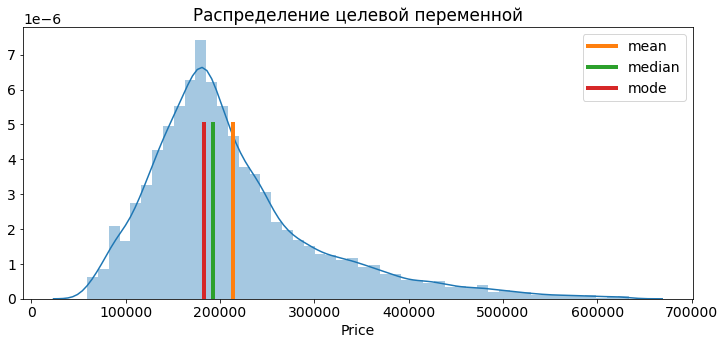

In [42]:
plt.figure(figsize=(12, 5))
sns.distplot(train_df['Price'], bins=50)
y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linewidth=4)

plt.title('Распределение целевой переменной')
plt.legend()
plt.show()

**Распределение целевой переменой выглядит вполне адекватно. Мало квартир с минимальной стоимостью, много квартир со средней стоимостью и мало дорогих квартир. Каких либо выбросов - не видно.**

**Количественные переменные.
Для вещественных признаков посмотрим на основные статистики.
Есть пропущенные данные и выбросы.**

In [43]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


**Номинативные переменные**

In [44]:
train_df.select_dtypes(include = 'category').columns.tolist()

['Ecology_2', 'Ecology_3', 'Shops_2']

In [45]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [46]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [47]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

**Выведем распределения признаков в графическом виде.
На графиках видно не совсем адекватные распределения - есть пропуски и выбросы.**

In [48]:
df_num_features = train_df.select_dtypes(include=['int32','int16','int8', 'float32'])

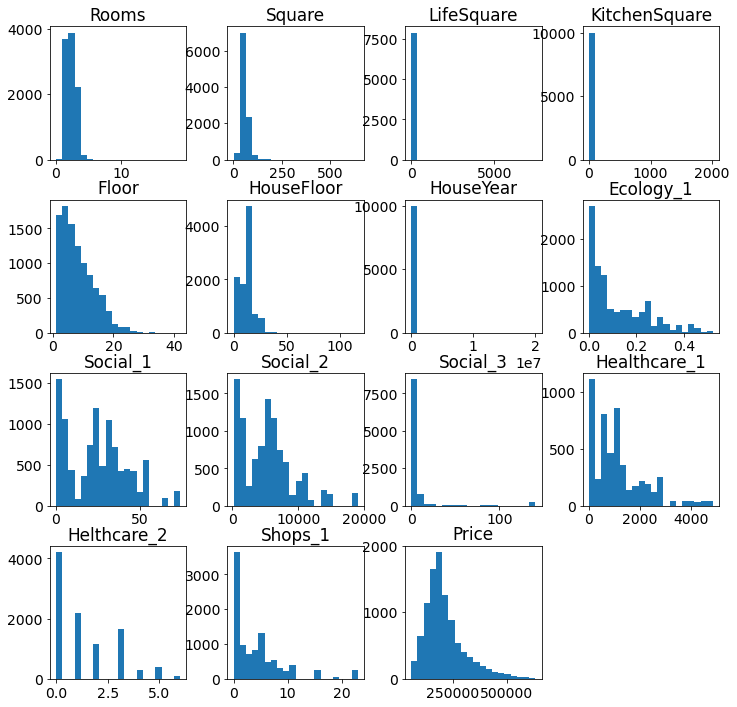

In [49]:
df_num_features.hist(figsize=(12, 12), bins=20, grid = False);

**Рассмотрим пропуски данных**

In [50]:
train_df.isna()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
9996,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
9997,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
9998,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [51]:
train_df.isna().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

**Пропуски данных обнаружены в двух признаках - LifeSquare и Healthcare_1**

### Обработка выбросов

**Признак Rooms**

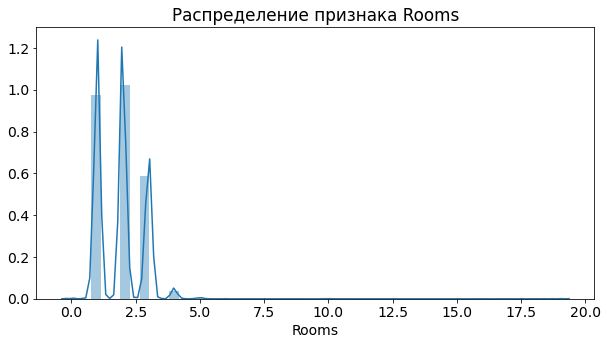

In [52]:
plt.figure(figsize = (10, 5))

sns.distplot(train_df['Rooms'], bins=50)
plt.title('Распределение признака Rooms')
plt.show()

In [53]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

**Квартиры с количеством комнат от 1 до 5 вполне реальны. Квартиры с 0 комнат - вполне могут оказаться студиями. Квартиры с 6 и более комнатами - скорее выбросы**

**Посомтрим на значения, которые могут быть выбросами**

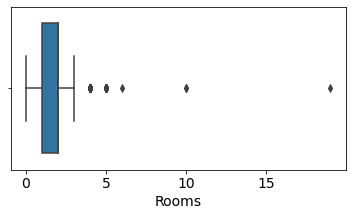

In [54]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['Rooms'], whis=1.5)

plt.xlabel('Rooms')
plt.show()

**Подсчитаем квантили**

In [55]:
rooms_max_value = np.quantile(train_df['Rooms'], q=0.975)
rooms_max_value

3.0

In [56]:
rooms_min_value = np.quantile(train_df['Rooms'], q=0.025)
rooms_min_value

1.0

**Очевидно, что данные квантили нам не подходят, т.к. квартиры бывают и 5 комнатные и менее 1 комнаты - квартиры студии. Однокомнатные квартиры более 125 м редкость.**

**Создадим дополнительный признак Rooms_outlier, в котором будем помечать сомнительные значения (0 - корректные данные; 1 - некорректные данные)**

In [57]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | \
             (train_df['Rooms'] >= 6 | \
              (train_df['Square'] > 125) & (train_df['Rooms'] == 1)), 'Rooms_outlier'] = 1
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000,1
1,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875,1
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750,1
3,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000,1
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750,1


**Заменим выбросы на медианы.**

In [58]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [59]:
train_df.loc[(train_df['Square'] > 125) & (train_df['Rooms'] == 1), 'Rooms'] = train_df['Rooms'].median()

**И проверит внесенные измененимя**

In [60]:
train_df['Rooms'].value_counts()

2.0    3895
1.0    3702
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

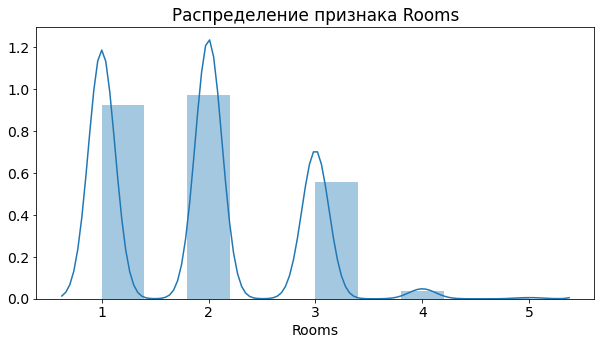

In [61]:
plt.figure(figsize = (10, 5))

sns.distplot(train_df['Rooms'], bins=10)
plt.title('Распределение признака Rooms')
plt.show()

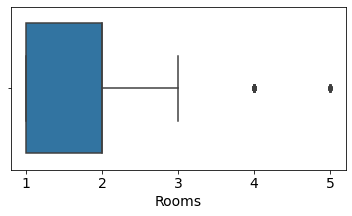

In [62]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['Rooms'], whis=1.5)

plt.xlabel('Rooms')
plt.show()

**Распределение признака Rooms стало более реалистичным.**

**Признак KitchenSquare**

**Распределение значений признака KitchenSquare.**

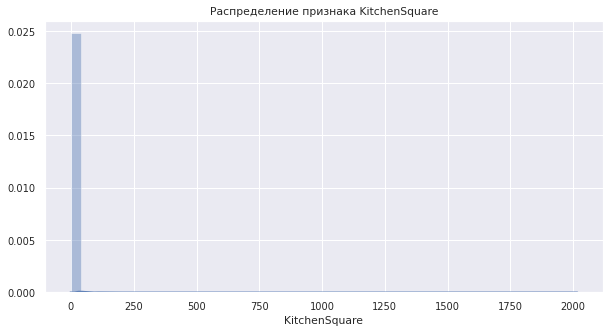

In [213]:
plt.figure(figsize = (10, 5))

sns.distplot(train_df['KitchenSquare'], bins=50)

plt.title("Распределение признака KitchenSquare")

plt.show()

In [64]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
43.0         2
112.0        2
41.0         2
32.0         2
58.0         2
25.0         2
37.0         2
30.0         2
51.0         2
40.0         1
96.0         1
48.0         1
72.0         1
73.0         1
2014.0       1
66.0         1
36.0         1
78.0         1
54.0         1
29.0         1
31.0         1
35.0         1
62.0         1
39.0         1
1970.0       1
60.0         1
75.0         1
26.0         1
21.0         1
84.0         1
63.0         1
123.0        1
53.0         1
42.0         1
23.0         1
27.0         1
Name: KitchenSquare, dtype: int64

**Значения, котрые могут быть выбросами**

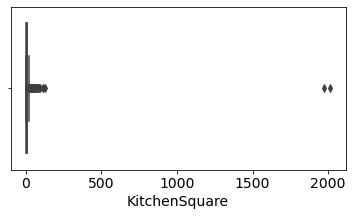

In [65]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['KitchenSquare'], whis=1.5)

plt.xlabel('KitchenSquare')
plt.show()

**Подсчитаем квантили.**

In [66]:
KitchenSquare_min_value = np.quantile(train_df['KitchenSquare'], q=0.025)
KitchenSquare_min_value

0.0

In [68]:
KitchenSquare_max_value = np.quantile(train_df['KitchenSquare'], q=0.975)
KitchenSquare_max_value

13.0

**На основании рыночных данных ("Циан") сделаем следующие предположения: минимальная кухня равна 3 м2, максимальную примем за 20 м2. При этом кухня менее 4м2 в квартирах с более чем 1 комнатной маловероятна.**

**Создадим дополнительный признак KitchenSquare_outlier, в котором будем помечать сомнительные значения (0 - корректные данные; 1 - некорректные данные)**

In [69]:
train_df['KitchenSquare_outlier'] = 0

In [70]:
train_df.loc[(train_df['KitchenSquare'] < 3) | (train_df['KitchenSquare'] > 20) | \
            ((train_df['KitchenSquare'] < 4) & (train_df['Rooms'] > 1)), 'KitchenSquare_outlier'] = 1

**Заменим сомнительные данные медианой.**

In [92]:
train_df.loc[(train_df['KitchenSquare'] < 3) | (train_df['KitchenSquare'] > 20),\
             'KitchenSquare'] = train_df['KitchenSquare'].median()

In [72]:
train_df.loc[((train_df['KitchenSquare'] < 4) & (train_df['Rooms'] > 1)), 'KitchenSquare'] = train_df['KitchenSquare'].median()

**Посмотрим, как теперь изменилось распределение значений признака KitchenSquare.**

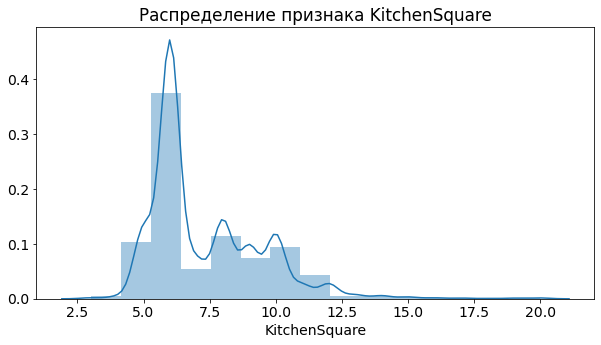

In [73]:
plt.figure(figsize = (10, 5))

sns.distplot(train_df['KitchenSquare'], bins=15)

plt.title("Распределение признака KitchenSquare")

plt.show()

**Посмотрим, какие значения могут быть выбросами.**

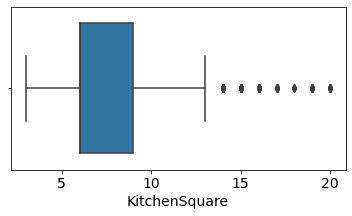

In [74]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['KitchenSquare'], whis=1.5)

plt.xlabel('KitchenSquare')
plt.show()

In [75]:
train_df['KitchenSquare'].value_counts()

6.0     4252
8.0     1306
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
14.0      51
4.0       39
15.0      31
3.0       17
16.0      16
20.0      14
17.0      12
19.0      11
18.0       6
Name: KitchenSquare, dtype: int64

**Все данные в рамках наших предположений.**

**Признак Square**

**Выведем на график распредение значений признака Square.**

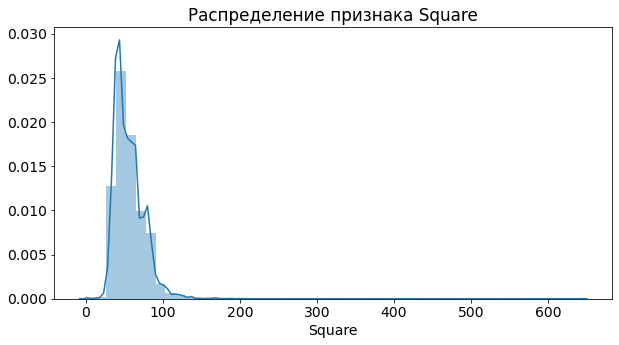

In [76]:
plt.figure(figsize = (10, 5))

sns.distplot(train_df['Square'], bins=50)
plt.title("Распределение признака Square")
plt.show()

**Определим значения, которые могут быть выбросами.**

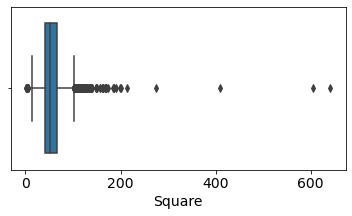

In [77]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['Square'], whis=1.5)

plt.xlabel('Square')
plt.show()

In [78]:
train_df['Square'].describe()

count    10000.000000
mean        56.315720
std         21.058716
min          1.136859
25%         41.774879
50%         52.513309
75%         65.900627
max        641.065186
Name: Square, dtype: float64

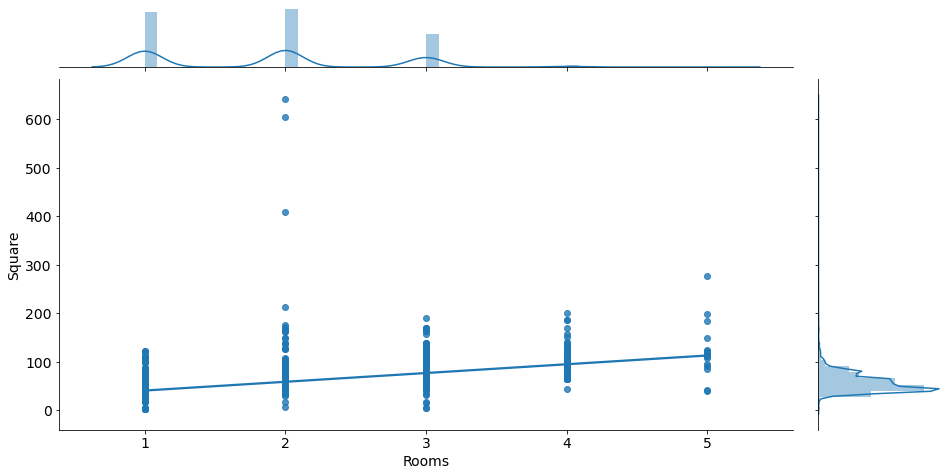

In [79]:
grid = sns.jointplot(train_df['Rooms'], train_df['Square'], kind='reg')
grid.fig.set_figwidth(15)
grid.fig.set_figheight(7)

plt.show()

**Как видно из вышепредставленного графика - основные выбросы признака Square состредоточены в 2-х комнатных квартирах.**

In [80]:
train_df.loc[train_df['Rooms'] == 2, 'Square'].describe()

count    3895.000000
mean       57.131290
std        18.474794
min         5.497061
25%        47.884493
50%        55.883114
75%        63.373276
max       641.065186
Name: Square, dtype: float64

In [81]:
train_df.loc[(train_df['Rooms'] == 2) & (train_df['Square'] > 180)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier
726,9,2.0,604.705994,NaN,6.0,17,18.0,1977,0.161532,B,...,25,5648,1,30.0,2,4,B,187717.250000,1,1
7010,102,2.0,409.425171,410.639740,10.0,4,4.0,2016,0.238617,B,...,26,3889,6,705.0,3,6,B,90470.429688,1,0
7644,27,2.0,212.932358,211.231125,6.0,2,3.0,2008,0.211401,B,...,9,1892,0,NaN,0,1,B,302211.250000,1,1
9229,30,2.0,641.065186,638.163208,10.0,20,19.0,2019,0.000078,B,...,22,6398,141,1046.0,3,23,B,133529.687500,1,0


**Высчитаем медиану признака Square для 2-х комнатных крартир**

In [82]:
train_df.loc[train_df['Rooms'] == 2, 'Square'].median()

55.883113861083984

**Создадим дополнительный признак Square_outlier, в котором будем помечать сомнительные значения (0 - корректные данные; 1 - некорректные данные)**

In [83]:
train_df['Square_outlier'] = 0

In [84]:
train_df.loc[((train_df['Rooms'] == 2) & (train_df['Square'] > 180)) | \
            (train_df['Square'] <= 20), 'Square_outlier'] = 1

**Заменим сомнительные данные.**

In [88]:
train_df.loc[(train_df['Rooms'] == 2) & (train_df['Square'] > 180),\
             'Square'] = train_df.loc[train_df['Rooms'] == 2, 'Square'].median()

**и посморим на изменения:**

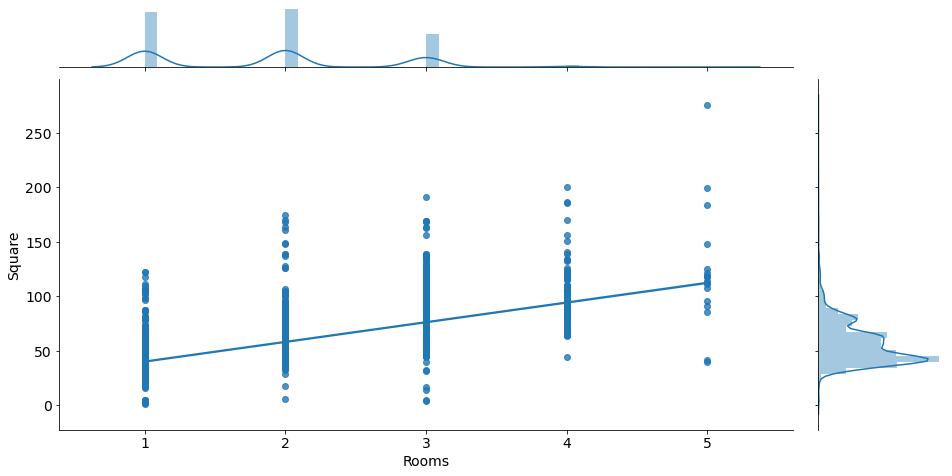

In [93]:
grid = sns.jointplot(train_df['Rooms'], train_df['Square'], kind='reg')
grid.fig.set_figwidth(15)
grid.fig.set_figheight(7)

plt.show()

**Предположим, что квартиры с площадью менее 20м2 тоже большая редкость и заменим значения на медиану**

In [94]:
train_df.loc[train_df['Square'] <= 20, 'Square'] = train_df['Square'].median()

**Посмотрим изменения на графиках:**

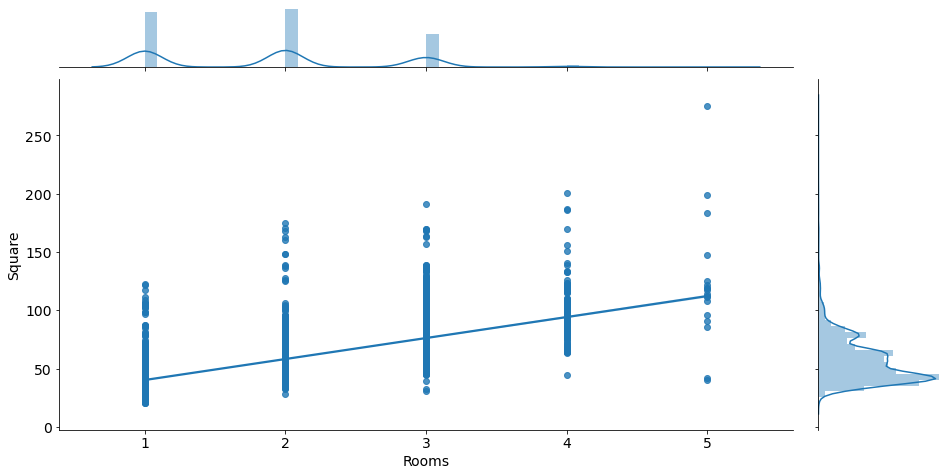

In [95]:
grid = sns.jointplot(train_df['Rooms'], train_df['Square'], kind='reg')
grid.fig.set_figwidth(15)
grid.fig.set_figheight(7)

plt.show()

**Значения, которые могут быть выбросами:**

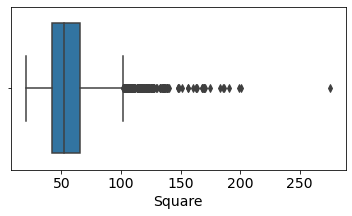

In [96]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['Square'], whis=1.5)

plt.xlabel('Square')
plt.show()

In [97]:
train_df['Square'].describe()

count    10000.000000
mean        56.241501
std         18.963213
min         20.213127
25%         41.811910
50%         52.513580
75%         65.889257
max        275.645294
Name: Square, dtype: float64

**Распределение значений признака Square после внесенных изменений выглядит вполне жизнеспособно:**

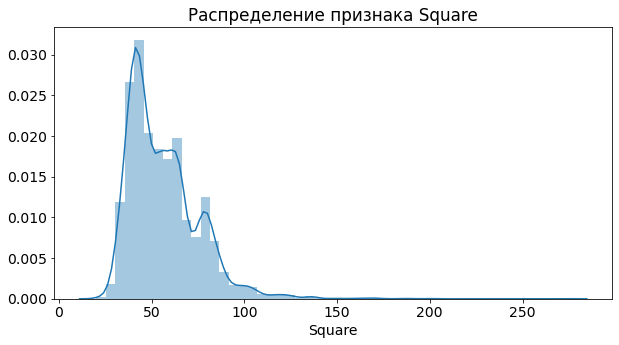

In [98]:
plt.figure(figsize = (10, 5))

sns.distplot(train_df['Square'], bins=50)
plt.title("Распределение признака Square")
plt.show()

**Признак LifeSquare**

**Распределение значений признака LifeSquare**

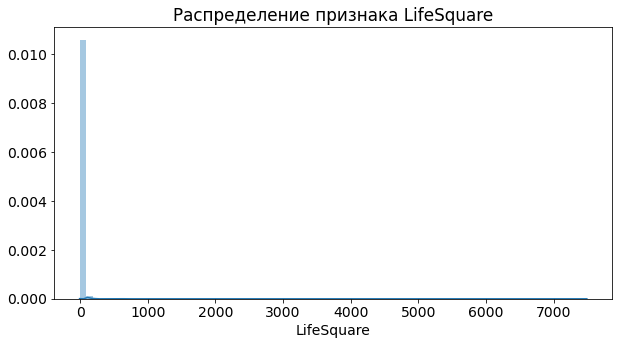

In [101]:
plt.figure(figsize = (10, 5))

sns.distplot(train_df['LifeSquare'], bins=80)
plt.title("Распределение признака LifeSquare")
plt.show()

**Посмотрим на взаимное распредение признаков Square и LifeSquare.** 

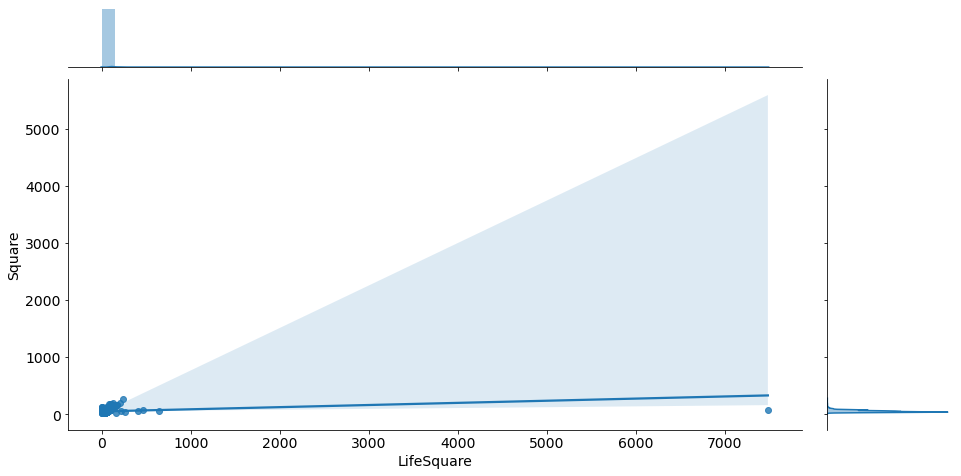

In [102]:
grid = sns.jointplot(train_df['LifeSquare'], train_df['Square'], kind='reg')
grid.fig.set_figwidth(15)
grid.fig.set_figheight(7)

plt.show()

In [103]:
train_df['LifeSquare'].describe()

count    7887.000000
mean       37.199665
std        86.241219
min         0.370619
25%        22.769833
50%        32.781261
75%        45.128803
max      7480.592285
Name: LifeSquare, dtype: float64

**Очень сомнительным выглядит максимальное значение признака LifeSquare** 

**Так же предположим, что жилая площадь не может быть менее 10 м2, а максимальня жилая площадь = общая площадь - площадь кухни - 10 (количество нежилой площади санузел, коридор, лоджии). Так же обработаем пропуски.**

**Создадим дополнительный признак LifeSquare_outlier, в котором будем помечать сомнительные значения (0 - корректные данные; 1 - некорректные данные)**

In [104]:
train_df['LifeSquare_outlier'] = 0

In [105]:
train_df.loc[(train_df['LifeSquare'].isna()) | \
             (train_df['LifeSquare'] > (train_df['Square'] - train_df['KitchenSquare'] - 10)) | \
             (train_df['LifeSquare'] / train_df['Rooms'] < 10), 'LifeSquare_outlier'] = 1

**и заменим данные, основываясь на наших предположениях:**

In [106]:
train_df.loc[(train_df['LifeSquare'].isna()) | \
             (train_df['LifeSquare'] > (train_df['Square'] - train_df['KitchenSquare'] - 10)) | \
             (train_df['LifeSquare'] / train_df['Rooms'] < 10), 'LifeSquare'] = \
             train_df['Square'] - train_df['KitchenSquare'] - 10

In [107]:
train_df.loc[train_df['LifeSquare'] < 10, 'LifeSquare'] = train_df['LifeSquare'].median() 

**Посмотрим на совместное распределение значений Square и LifeSquare после внесенных изменений.**

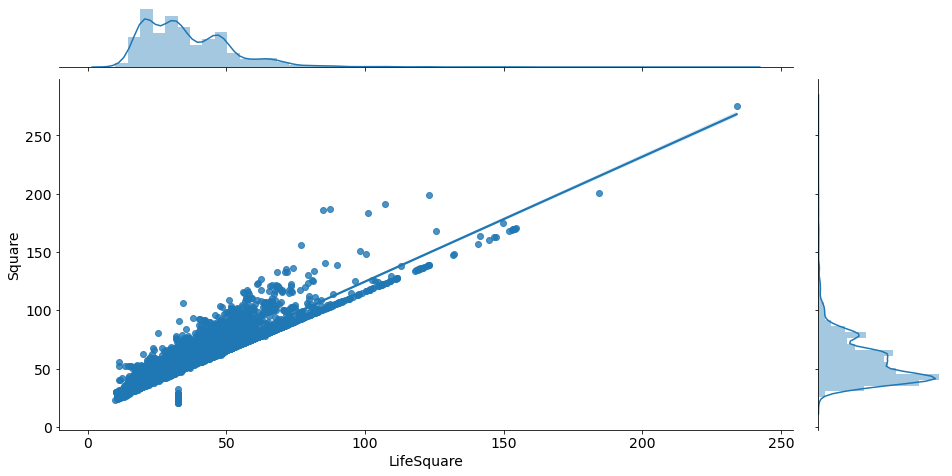

In [108]:
grid = sns.jointplot(train_df['LifeSquare'], train_df['Square'], kind='reg')
grid.fig.set_figwidth(15)
grid.fig.set_figheight(7)

plt.show()

**Распределение значений признака LifeSquare**

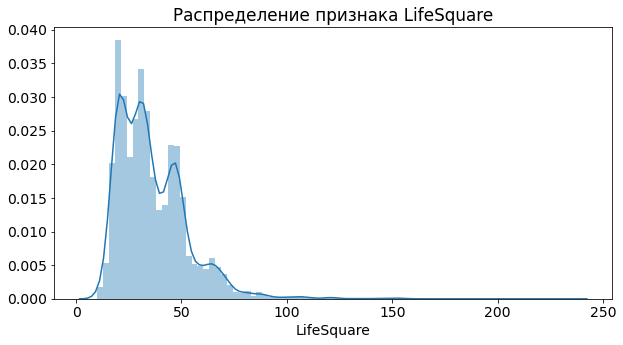

In [109]:
plt.figure(figsize = (10, 5))

sns.distplot(train_df['LifeSquare'], bins=80)
plt.title("Распределение признака LifeSquare")
plt.show()

In [110]:
train_df['LifeSquare'].describe()

count    10000.000000
mean        36.132008
std         16.608252
min         10.015919
25%         23.192579
50%         32.412128
75%         45.763492
max        233.949310
Name: LifeSquare, dtype: float64

In [111]:
train_df['LifeSquare'].isna().sum()

0

**Распределение выглядит достаточно реалистично и пропуски также были обработаны.** 

**Признаки HouseFloor и Floor**

**Для данных признаков выджвинем следующие предположения:
Значения признаков не могут быть равными 0 и больше 57 (Самое высокое жилое здание в Москве по состоянию на май 2021 года  - это "Триумф палас"), этаж продаваемой квартиры не может быть больше количества этажей в доме (HouseFloor >= Floor).**

**Распределение значений признака HouseFloor**

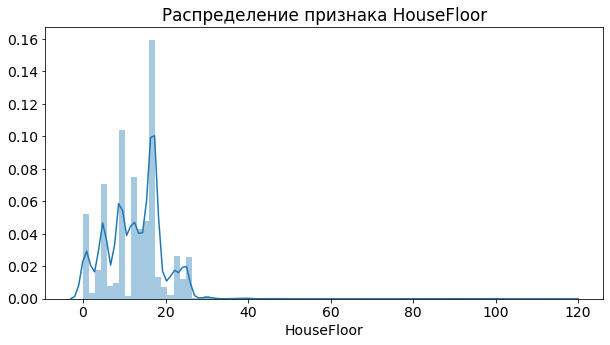

In [112]:
plt.figure(figsize = (10, 5))

sns.distplot(train_df['HouseFloor'], bins=80)
plt.title("Распределение признака HouseFloor")
plt.show()

**Посмотрим на уникальные значения признака.**

In [113]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
      dtype=float32)

**Значения 0, 99, 117 - это выбросы**

**Распределение значений признака Floor**

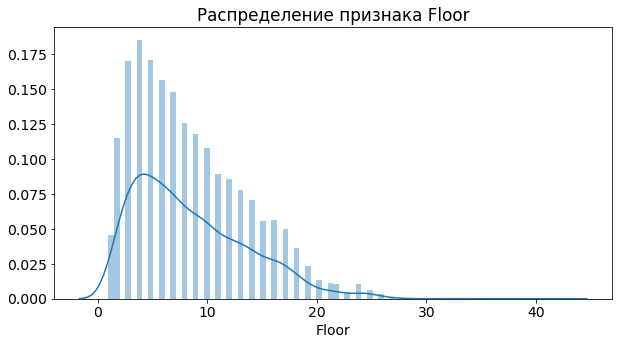

In [114]:
plt.figure(figsize = (10, 5))

sns.distplot(train_df['Floor'], bins=80)
plt.title("Распределение признака Floor")
plt.show()

In [115]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

**Значения удовлетворяют выдвинутой ранее гипотезе**

**Количество объектов, где этаж квартиры больше, чем этажность дома.** 

In [116]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

**Создадим дополнительный признак HouseFloor_outlier, в котором будем помечать сомнительные значения (0 - корректные данные; 1 - некорректные данные)**

In [117]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1
train_df.loc[train_df['HouseFloor'] > 57, 'HouseFloor_outlier'] = 1

**Заменим некорректные значения на медиану**

In [118]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [119]:
train_df.loc[train_df['HouseFloor'] > 57, 'HouseFloor'] = train_df['HouseFloor'].median()

**Отберем по индексу те объекты, в которых этаж квартиры больше количества этажей в доме**

In [120]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

**и заменим их на произвольное значение в диапазоне количества этажей в доме**

In [121]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

**Проверим количество объектов, где этаж квартиры больше количества этажей в доме.**

In [122]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

**Распределеине значений признакак HouseFloor после внесенных изменений.**

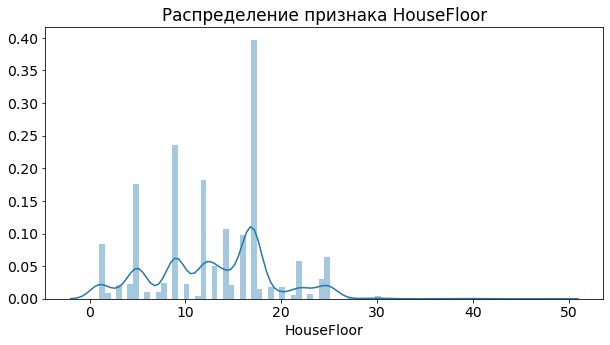

In [123]:
plt.figure(figsize = (10, 5))

sns.distplot(train_df['HouseFloor'], bins=80)
plt.title("Распределение признака HouseFloor")
plt.show()

In [124]:
train_df['HouseFloor'].describe()

count    10000.00000
mean        12.93150
std          6.24144
min          1.00000
25%          9.00000
50%         13.00000
75%         17.00000
max         48.00000
Name: HouseFloor, dtype: float64

**Самый часто встречающийся этаж продаваемых объектов.**

In [125]:
train_df['HouseFloor'].mode()

0    17.0
dtype: float32

**Признак HouseYear**

In [127]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7246        2020
2350        2020
8296        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int32

**Выбросы 20052011 - это скорее всего годы постройки, можно заменить на 2011, а 4968 это скорее всего 1968, но поскольку таких объектов всего 2, то сделаем универсальную обработку. Если дата постройки дома более сегодняшней даты - то устанавливаем зданию текущий годю**

In [128]:
train_df.loc[(train_df['HouseYear'] > datetime.now().year), 'HouseYear'] = datetime.now().year

**Проверяем данные после внесенных изменений**

In [129]:
train_df['HouseYear'].sort_values(ascending=False)

8828    2021
9163    2021
7246    2020
2350    2020
8296    2020
        ... 
7610    1916
6250    1914
2066    1912
2795    1912
6794    1910
Name: HouseYear, Length: 10000, dtype: int32

**Признаки Ecology_1 - Shops_2**

**Признак Ecology_1**

**Посмотрим на распределение значений признака Ecology_1**

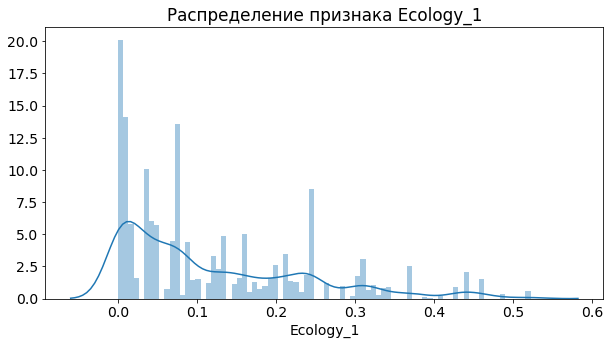

In [130]:
plt.figure(figsize = (10, 5))

sns.distplot(train_df['Ecology_1'], bins=80)
plt.title("Распределение признака Ecology_1")
plt.show()

**Значения признака Ecology_1, которые могут быть выбросами**

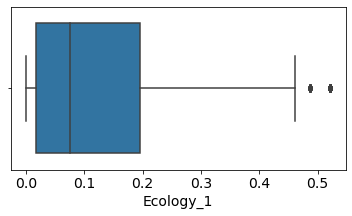

In [131]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['Ecology_1'], whis=1.5)

plt.xlabel('Ecology_1')
plt.show()

**Заменим эти значения на медиану**

In [132]:
train_df.loc[train_df['Ecology_1']>0.46, 'Ecology_1'] = train_df['Ecology_1'].median()

**Проверим значения признака Ecology_1, после корректировки**

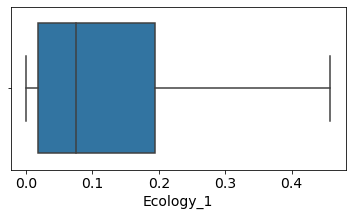

In [133]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['Ecology_1'], whis=1.5)

plt.xlabel('Ecology_1')
plt.show()

**Признак Social_1**

**Значения признака Social_1, которые могут быть выбросами**

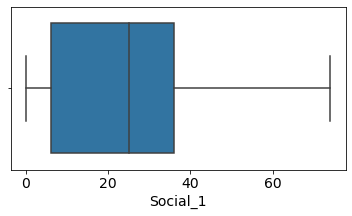

In [135]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['Social_1'], whis=1.5)

plt.xlabel('Social_1')
plt.show()

**С данными все в порядке - корректировок не требуется.**

**Признак Social_2**

**Значения признака Social_2, которые могут быть выбросами**

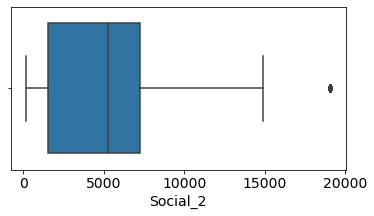

In [136]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['Social_2'], whis=1.5)

plt.xlabel('Social_2')
plt.show()

**Корректируем выбросы**

In [137]:
train_df.loc[train_df['Social_2']>15000, 'Social_2'] = train_df['Social_2'].median()

**и проверяем:**

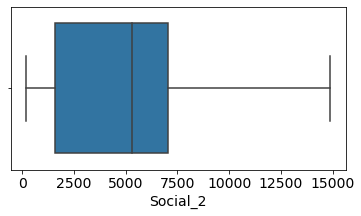

In [138]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['Social_2'], whis=1.5)

plt.xlabel('Social_2')
plt.show()

**Признак Social_3**

**Значения признака Social_3, которые могут быть выбросами**

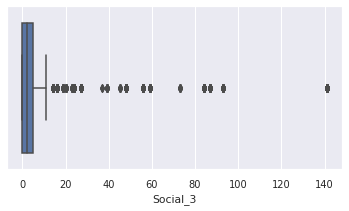

In [214]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['Social_3'], whis=1.5)

plt.xlabel('Social_3')
plt.show()

**3аменяем эти значения**

In [140]:
train_df.loc[train_df['Social_3'] > 12, 'Social_3'] = train_df['Social_3'].median()

**и проверяем:**

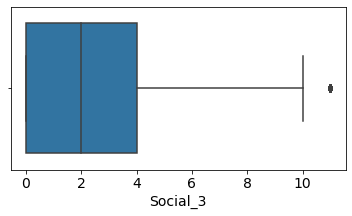

In [141]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['Social_3'], whis=1.5)

plt.xlabel('Social_3')
plt.show()

**Признак Helthcare_2**

**Значения признака Helthcare_2, которые могут быть выбросами**

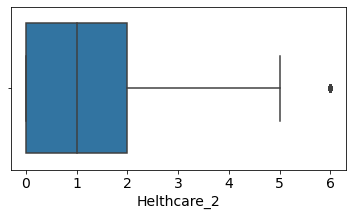

In [142]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['Helthcare_2'], whis=1.5)

plt.xlabel('Helthcare_2')
plt.show()

**Оставляем, как есть.**

**Признак Shops_1**

**Значения признака Shops_1, которые могут быть выбросами**

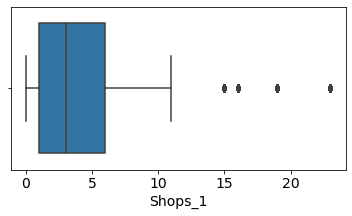

In [143]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['Shops_1'], whis=1.5)

plt.xlabel('Shops_1')
plt.show()

**Заменяем некорректые значения:**

In [144]:
train_df.loc[train_df['Shops_1'] > 12, 'Shops_1'] = train_df['Shops_1'].median()

**и проверяем**

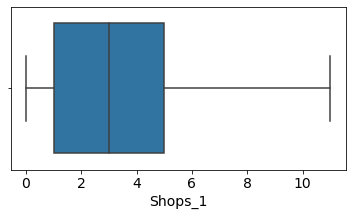

In [145]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['Shops_1'], whis=1.5)

plt.xlabel('Shops_1')
plt.show()

### Обработка пропусков

In [146]:
train_df.isna().sum()

DistrictId                  0
Rooms                       0
Square                      0
LifeSquare                  0
KitchenSquare               0
Floor                       0
HouseFloor                  0
HouseYear                   0
Ecology_1                   0
Ecology_2                   0
Ecology_3                   0
Social_1                    0
Social_2                    0
Social_3                    0
Healthcare_1             4798
Helthcare_2                 0
Shops_1                     0
Shops_2                     0
Price                       0
Rooms_outlier               0
KitchenSquare_outlier       0
Square_outlier              0
LifeSquare_outlier          0
HouseFloor_outlier          0
dtype: int64

**Пропуски присутствуют только в признаке "Healthcare_1" и их очень много - около 50%. Удалим этот признак.**

In [147]:
train_df.drop('Healthcare_1', axis = 1, inplace = True)

**Все вышеперечисленные корректировки признаков оформим в виде класса:**

In [148]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
       
        
       
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
    
    
    
    def transform(self, X):
        """Трансформация данных"""

              
        # Rooms
        
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | \
             (X['Rooms'] >= 6 | \
             (X['Square'] > 125) & (X['Rooms'] == 1)), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = X['Rooms'].median()
        X.loc[(X['Square'] > 125) & (X['Rooms'] == 1), 'Rooms'] = self.medians['Rooms']
        
                
        # KitchenSquare
        
        X['KitchenSquare_outlier'] = 0
        X.loc[(X['KitchenSquare'] < 3) | (X['KitchenSquare'] > 20) | \
            ((X['KitchenSquare'] < 4) & (X['Rooms'] > 1)), 'KitchenSquare_outlier'] = 1
        
        
        X.loc[(X['KitchenSquare'] < 3) | (X['KitchenSquare'] > 20), 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[((X['KitchenSquare'] < 4) & (X['Rooms'] > 1)), 'KitchenSquare'] = self.medians['KitchenSquare']
        
        
        # Square
        
        X['Square_outlier'] = 0
        X.loc[((X['Rooms'] == 2) & (X['Square'] > 180)) | (X['Square'] <= 20), 'Square_outlier'] = 1
        
        X.loc[(X['Rooms'] == 2) & (X['Square'] > 180), 'Square'] = X.loc[X['Rooms'] == 2, 'Square'].median()
        X.loc[X['Square'] <= 20, 'Square'] = self.medians['Square']
        
        
        # LifeSquare
        
        X['LifeSquare_outlier'] = 0
        X.loc[(X['LifeSquare'].isna()) | (X['LifeSquare'] > (X['Square'] - X['KitchenSquare'] - 10)) | \
             (X['LifeSquare'] / X['Rooms'] < 10), 'LifeSquare_outlier'] = 1
        
        
        X.loc[(X['LifeSquare'].isna()) | (X['LifeSquare'] > (X['Square'] - X['KitchenSquare'] - 10)) | \
             (X['LifeSquare'] / X['Rooms'] < 10), 'LifeSquare'] = X['Square'] - X['KitchenSquare'] - 10
        
        X.loc[X['LifeSquare'] < 10, 'LifeSquare'] = self.medians['LifeSquare'] 
        
                
        # HouseFloor, Floor 
        
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        X.loc[X['HouseFloor'] > 57, 'HouseFloor_outlier'] = 1
        
        X.loc[(X['HouseFloor'] == 0) | (X['HouseFloor'] > 57), 'HouseFloor'] = self.medians['HouseFloor']
             
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))
        
        
        # HouseYear
        
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)

        
        #Ecology_1
        X.loc[X['Ecology_1']>0.46, 'Ecology_1'] = self.medians['Ecology_1']
        
        #Social_2
        X.loc[X['Social_2']>15000, 'Social_2'] = self.medians['Social_2']
        
        #Social_3
        X.loc[X['Social_3'] > 12, 'Social_3'] = self.medians['Social_3']
        
        #Shops_1
        X.loc[X['Shops_1'] > 12, 'Shops_1'] = self.medians['Shops_1']
        
               
        X.fillna(self.medians, inplace=True)
               
        
        return X


### Построение новых признаков

**Ecology_2, Ecology_3, Shops_2**

In [149]:
train_df.select_dtypes(include='category').columns.tolist()

['Ecology_2', 'Ecology_3', 'Shops_2']

**Переведем признаки из строкового типа в цифровой - {'A': 0, 'B': 1}**

In [150]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

**DistrictSize, IsDistrictLarge**

**Создадим новый вспомогательный признак - DistrictSize, который будет основан на количестве домов в каждом районе**

In [151]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


**Присоединяем новый признак к датафрейму**

In [152]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,HouseFloor_outlier,DistrictSize
0,27,3.0,115.027313,95.027313,10.0,4,10.0,2014,0.075424,1,...,0,0.0,1,305018.875000,1,0,0,1,0,851
1,22,1.0,39.832523,21.832523,8.0,7,8.0,1966,0.118537,1,...,1,0.0,1,177734.546875,1,0,0,1,0,78
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,...,3,1.0,1,282078.718750,1,0,0,0,0,652
3,1,1.0,40.409908,24.409908,6.0,10,22.0,1977,0.007122,1,...,0,1.0,1,168106.000000,1,1,0,1,0,652
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,1,...,0,6.0,1,343995.093750,1,0,0,0,0,89


**IsDistrictLarge. Предположим, что район большой, если в нем продается на данный момент более 200 квартир.**

In [153]:
(train_df['DistrictSize'] > 200).value_counts()

False    6652
True     3348
Name: DistrictSize, dtype: int64

**Добавим новый признак в датасет, как бинарный признак.**

In [154]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 200).astype(int)

In [155]:
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,HouseFloor_outlier,DistrictSize,IsDistrictLarge
0,27,3.0,115.027313,95.027313,10.0,4,10.0,2014,0.075424,1,...,0.0,1,305018.875000,1,0,0,1,0,851,1
1,22,1.0,39.832523,21.832523,8.0,7,8.0,1966,0.118537,1,...,0.0,1,177734.546875,1,0,0,1,0,78,0
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,...,1.0,1,282078.718750,1,0,0,0,0,652,1
3,1,1.0,40.409908,24.409908,6.0,10,22.0,1977,0.007122,1,...,1.0,1,168106.000000,1,1,0,1,0,652,1
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,1,...,6.0,1,343995.093750,1,0,0,0,0,89,0


**Med_price_by_district**

In [156]:
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [157]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.437500
1,0,2.0,176210.812500
2,0,3.0,300610.375000
3,1,1.0,146735.671875
4,1,2.0,202666.312500


In [158]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,HouseFloor_outlier,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,27,3.0,115.027313,95.027313,10.0,4,10.0,2014,0.075424,1,...,1,305018.875000,1,0,0,1,0,851,1,213530.781250
1,22,1.0,39.832523,21.832523,8.0,7,8.0,1966,0.118537,1,...,1,177734.546875,1,0,0,1,0,78,0,146032.828125
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,...,1,282078.718750,1,0,0,0,0,652,1,244005.281250
3,1,1.0,40.409908,24.409908,6.0,10,22.0,1977,0.007122,1,...,1,168106.000000,1,1,0,1,0,652,1,146735.671875
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,1,...,1,343995.093750,1,0,0,0,0,89,0,201584.437500


**Создаем новые категориальные признаки из вещественных. Оформляем в виде функций.**

In [159]:
# из этажа квартиры:
def floor_to_cat(X):
    bins = [X['Floor'].min(), 3, 5, 9, 16, 25, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X

# из года постройки дома:
def year_to_cat(X):
    bins = [X['HouseYear'].min(), 1940, 1950, 1960, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

# из площади квартиры:
def square_to_cat(X):
    bins = [X['Square'].min(), 40, 60, 80, 120, X['Square'].max()]
    X['square_cat'] = pd.cut(X['Square'], bins=bins, labels=False)
    
    X['square_cat'].fillna(-1, inplace=True)
    return X

**Вызываем функции и проверяем внесенные изменения**

In [160]:
train_df = floor_to_cat(train_df)
train_df = year_to_cat(train_df)
train_df = square_to_cat(train_df)
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,HouseFloor_outlier,DistrictSize,IsDistrictLarge,MedPriceByDistrict,floor_cat,year_cat,square_cat
0,27,3.0,115.027313,95.027313,10.0,4,10.0,2014,0.075424,1,...,0,0,1,0,851,1,213530.781250,1.0,6.0,3.0
1,22,1.0,39.832523,21.832523,8.0,7,8.0,1966,0.118537,1,...,0,0,1,0,78,0,146032.828125,2.0,3.0,0.0
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,...,0,0,0,0,652,1,244005.281250,0.0,4.0,2.0
3,1,1.0,40.409908,24.409908,6.0,10,22.0,1977,0.007122,1,...,1,0,1,0,652,1,146735.671875,3.0,3.0,1.0
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,1,...,0,0,0,0,89,0,201584.437500,3.0,3.0,2.0


**med_price_by_floor_year**

In [161]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,-1.0,2.0,287954.71875
1,0.0,-1.0,263299.71875
2,0.0,0.0,406187.68750
3,0.0,1.0,333877.71875
4,0.0,2.0,436548.37500


In [162]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Square_outlier,LifeSquare_outlier,HouseFloor_outlier,DistrictSize,IsDistrictLarge,MedPriceByDistrict,floor_cat,year_cat,square_cat,MedPriceByFloorYear
0,27,3.0,115.027313,95.027313,10.0,4,10.0,2014,0.075424,1,...,0,1,0,851,1,213530.781250,1.0,6.0,3.0,167338.78125
1,22,1.0,39.832523,21.832523,8.0,7,8.0,1966,0.118537,1,...,0,1,0,78,0,146032.828125,2.0,3.0,0.0,190296.56250
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,...,0,0,0,652,1,244005.281250,0.0,4.0,2.0,204670.09375
3,1,1.0,40.409908,24.409908,6.0,10,22.0,1977,0.007122,1,...,0,1,0,652,1,146735.671875,3.0,3.0,1.0,182150.56250
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,1,...,0,0,0,89,0,201584.437500,3.0,3.0,2.0,182150.56250


**med_price_by_square_cat**

In [163]:
med_price_by_square_cat = train_df.groupby('square_cat', as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySquare'})
med_price_by_square_cat.head()

,square_cat,MedPriceBySquare
0,-1.0,113050.226562
1,0.0,158785.531250
2,1.0,183733.500000
3,2.0,229847.406250
4,3.0,297390.687500


In [164]:
train_df = train_df.merge(med_price_by_square_cat, on='square_cat', how='left')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,LifeSquare_outlier,HouseFloor_outlier,DistrictSize,IsDistrictLarge,MedPriceByDistrict,floor_cat,year_cat,square_cat,MedPriceByFloorYear,MedPriceBySquare
0,27,3.0,115.027313,95.027313,10.0,4,10.0,2014,0.075424,1,...,1,0,851,1,213530.781250,1.0,6.0,3.0,167338.78125,297390.68750
1,22,1.0,39.832523,21.832523,8.0,7,8.0,1966,0.118537,1,...,1,0,78,0,146032.828125,2.0,3.0,0.0,190296.56250,158785.53125
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,...,0,0,652,1,244005.281250,0.0,4.0,2.0,204670.09375,229847.40625
3,1,1.0,40.409908,24.409908,6.0,10,22.0,1977,0.007122,1,...,1,0,652,1,146735.671875,3.0,3.0,1.0,182150.56250,183733.50000
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,1,...,0,0,89,0,201584.437500,3.0,3.0,2.0,182150.56250,229847.40625


**med_price_by_social_1**

In [165]:
med_price_by_social_1 = train_df.groupby('Social_1', as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySocial_1'})
med_price_by_social_1.head()

,Social_1,MedPriceBySocial_1
0,0,96009.210938
1,1,175732.062500
2,2,161357.593750
3,3,114687.367188
4,4,124121.109375


In [166]:
train_df = train_df.merge(med_price_by_social_1, on='Social_1', how='left')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,HouseFloor_outlier,DistrictSize,IsDistrictLarge,MedPriceByDistrict,floor_cat,year_cat,square_cat,MedPriceByFloorYear,MedPriceBySquare,MedPriceBySocial_1
0,27,3.0,115.027313,95.027313,10.0,4,10.0,2014,0.075424,1,...,0,851,1,213530.781250,1.0,6.0,3.0,167338.78125,297390.68750,163954.531250
1,22,1.0,39.832523,21.832523,8.0,7,8.0,1966,0.118537,1,...,0,78,0,146032.828125,2.0,3.0,0.0,190296.56250,158785.53125,194439.953125
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,...,0,652,1,244005.281250,0.0,4.0,2.0,204670.09375,229847.40625,219892.968750
3,1,1.0,40.409908,24.409908,6.0,10,22.0,1977,0.007122,1,...,0,652,1,146735.671875,3.0,3.0,1.0,182150.56250,183733.50000,175732.062500
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,1,...,0,89,0,201584.437500,3.0,3.0,2.0,182150.56250,229847.40625,219892.968750


**med_price_by_Helthcare_2**

In [167]:
med_price_by_Helthcare_2 = train_df.groupby('Helthcare_2', as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByHelthcare_2'})
med_price_by_Helthcare_2.head()

,Helthcare_2,MedPriceByHelthcare_2
0,0,169383.06250
1,1,216133.46875
2,2,198882.37500
3,3,204197.96875
4,4,240621.37500


In [168]:
train_df = train_df.merge(med_price_by_Helthcare_2, on='Helthcare_2', how='left')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,DistrictSize,IsDistrictLarge,MedPriceByDistrict,floor_cat,year_cat,square_cat,MedPriceByFloorYear,MedPriceBySquare,MedPriceBySocial_1,MedPriceByHelthcare_2
0,27,3.0,115.027313,95.027313,10.0,4,10.0,2014,0.075424,1,...,851,1,213530.781250,1.0,6.0,3.0,167338.78125,297390.68750,163954.531250,169383.06250
1,22,1.0,39.832523,21.832523,8.0,7,8.0,1966,0.118537,1,...,78,0,146032.828125,2.0,3.0,0.0,190296.56250,158785.53125,194439.953125,216133.46875
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,...,652,1,244005.281250,0.0,4.0,2.0,204670.09375,229847.40625,219892.968750,204197.96875
3,1,1.0,40.409908,24.409908,6.0,10,22.0,1977,0.007122,1,...,652,1,146735.671875,3.0,3.0,1.0,182150.56250,183733.50000,175732.062500,169383.06250
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,1,...,89,0,201584.437500,3.0,3.0,2.0,182150.56250,229847.40625,219892.968750,169383.06250


**med_price_by_Shops_1**

In [169]:
med_price_by_Shops_1 = train_df.groupby('Shops_1', as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByShops_1'})
med_price_by_Shops_1.head()

,Shops_1,MedPriceByShops_1
0,0.0,161573.046875
1,1.0,188768.312500
2,2.0,182814.218750
3,3.0,207836.812500
4,4.0,197512.515625


In [170]:
train_df = train_df.merge(med_price_by_Shops_1, on='Shops_1', how='left')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,IsDistrictLarge,MedPriceByDistrict,floor_cat,year_cat,square_cat,MedPriceByFloorYear,MedPriceBySquare,MedPriceBySocial_1,MedPriceByHelthcare_2,MedPriceByShops_1
0,27,3.0,115.027313,95.027313,10.0,4,10.0,2014,0.075424,1,...,1,213530.781250,1.0,6.0,3.0,167338.78125,297390.68750,163954.531250,169383.06250,161573.046875
1,22,1.0,39.832523,21.832523,8.0,7,8.0,1966,0.118537,1,...,0,146032.828125,2.0,3.0,0.0,190296.56250,158785.53125,194439.953125,216133.46875,161573.046875
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,...,1,244005.281250,0.0,4.0,2.0,204670.09375,229847.40625,219892.968750,204197.96875,188768.312500
3,1,1.0,40.409908,24.409908,6.0,10,22.0,1977,0.007122,1,...,1,146735.671875,3.0,3.0,1.0,182150.56250,183733.50000,175732.062500,169383.06250,188768.312500
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,1,...,0,201584.437500,3.0,3.0,2.0,182150.56250,229847.40625,219892.968750,169383.06250,215409.890625


**Оформим формирование новых признаков в виде класса.**

In [171]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        self.med_price_by_square_cat = None
        self.med_price_by_social_1 = None
        self.med_price_by_Helthcare_2 = None
        self.med_price_by_Shops_1 = None
        
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year, square
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            self.square_max = df['Square'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            df = self.square_to_cat(df)
            
            
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
            
            self.med_price_by_square_cat = df.groupby('square_cat', as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySquare'})
            self.med_price_by_square_cat_median = self.med_price_by_square_cat['MedPriceBySquare'].median()
            
            self.med_price_by_social_1 = df.groupby('Social_1', as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySocial_1'})
            self.med_price_by_social_1_median = self.med_price_by_social_1['MedPriceBySocial_1'].median()
            
            self.med_price_by_Helthcare_2 = df.groupby('Helthcare_2', as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByHelthcare_2'})
            self.med_price_by_Helthcare_2_median = self.med_price_by_Helthcare_2['MedPriceByHelthcare_2'].median()
            
            self.med_price_by_Shops_1 = df.groupby('Shops_1', as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByShops_1'})
            self.med_price_by_Shops_1_median = self.med_price_by_Shops_1['MedPriceByShops_1'].median()
            
            

            
            
        
    def transform(self, X):
        
        # Binary features
        
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 200).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        X = self.square_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
        
        if self.med_price_by_square_cat is not None:
            X = X.merge(med_price_by_square_cat, on='square_cat', how='left')
            X.fillna(self.med_price_by_square_cat_median, inplace=True)
        
        if self.med_price_by_social_1 is not None:
            X = X.merge(med_price_by_social_1, on='Social_1', how='left')
            X.fillna(self.med_price_by_social_1_median, inplace=True)
        
        if self.med_price_by_Helthcare_2 is not None:
            X = X.merge(med_price_by_Helthcare_2, on='Helthcare_2', how='left')
            X.fillna(self.med_price_by_Helthcare_2_median, inplace=True)
        
        if self.med_price_by_Shops_1 is not None:
            X = X.merge(med_price_by_Shops_1, on='Shops_1', how='left')
            X.fillna(self.med_price_by_Shops_1_median, inplace=True)
            
          
        return X
    
    
        # из этажа квартиры 
    def floor_to_cat(self, X):
        bins = [X['Floor'].min(), 3, 5, 9, 16, 25, X['Floor'].max()]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
        X['floor_cat'].fillna(-1, inplace=True)
        
        return X

    # из года постройки дома 
    def year_to_cat(self, X):
        bins = [X['HouseYear'].min(), 1940, 1950, 1960, 1980, 2000, 2010, X['HouseYear'].max()]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
        X['year_cat'].fillna(-1, inplace=True)
        
        return X

    # из площади квартиры 
    def square_to_cat(self, X):
        bins = [X['Square'].min(), 40, 60, 80, 120, X['Square'].max()]
        X['square_cat'] = pd.cut(X['Square'], bins=bins, labels=False)
        X['square_cat'].fillna(-1, inplace=True)
        
        return X

### Отбор признаков

In [172]:
train_df.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'KitchenSquare_outlier',
 'Square_outlier',
 'LifeSquare_outlier',
 'HouseFloor_outlier',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'floor_cat',
 'year_cat',
 'square_cat',
 'MedPriceByFloorYear',
 'MedPriceBySquare',
 'MedPriceBySocial_1',
 'MedPriceByHelthcare_2',
 'MedPriceByShops_1']

**Выберем признаки, на которых будем обучаться:**

In [183]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1']

new_feature_names = ['KitchenSquare_outlier', 'LifeSquare_outlier',
 'HouseFloor_outlier', 'DistrictSize', 'IsDistrictLarge', 'MedPriceByDistrict', 
 'MedPriceByFloorYear', 'MedPriceBySquare', 'MedPriceBySocial_1', 'MedPriceByShops_1',
 'MedPriceByHelthcare_2']
target_name = 'Price'

### Разбиение на train и test

In [184]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns = target_name)
y = train_df[target_name]

In [185]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [186]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 24), (3300, 24), (5000, 24))

In [187]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 36), (3300, 36), (5000, 36))

In [179]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [188]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

**Создадим корреляционную матрицу, для анализа сильно коррелирующих признаков**

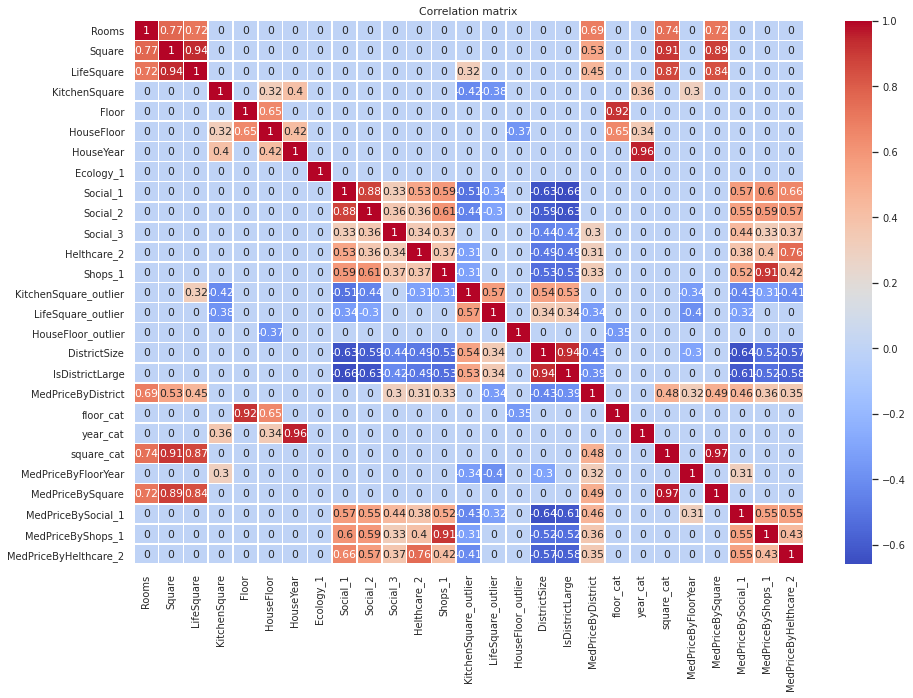

In [182]:
plt.figure(figsize=(15, 10))

sns.set(font_scale = 0.9)
corr_matrix = X_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0
sns.heatmap(corr_matrix, annot = True, linewidths=.5, cmap = 'coolwarm')
plt.title('Correlation matrix')
plt.show()

### Обучение различных моделей

**LinearRegression**

Train R2:	0.728
Test R2:	0.642


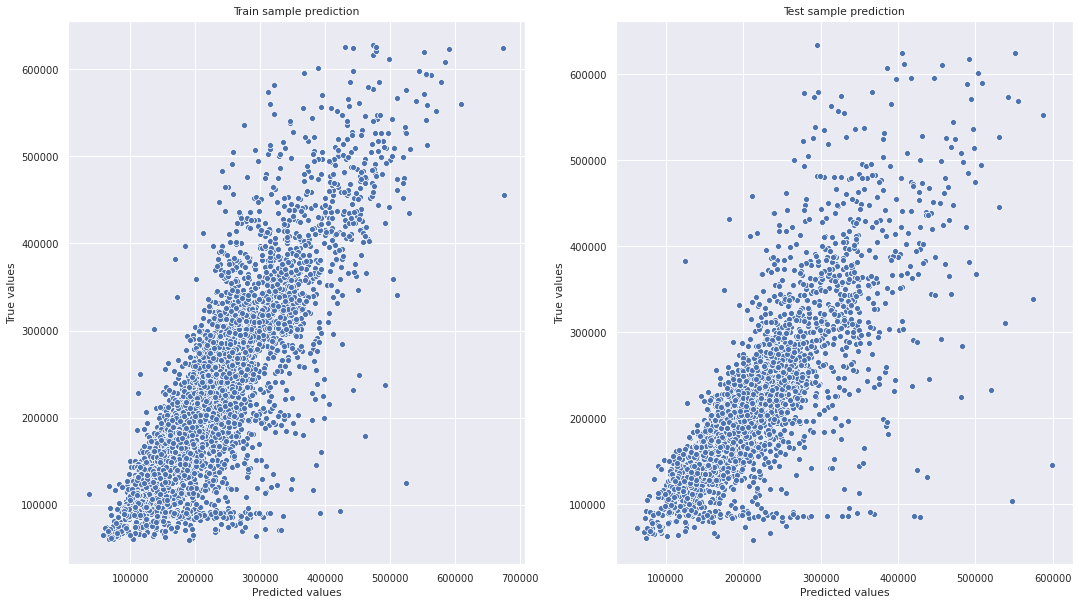

In [189]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_train_preds = lr_model.predict(X_train)
y_test_preds = lr_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

**RandomForest**

In [191]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=50, # глубина дерева  
                                 min_samples_leaf=25, # минимальное кол-во наблюдений в листе дерева
                                 max_features='log2',
                                 random_state=42, 
                                 n_estimators=500  # кол-во деревьев
                                 )
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=50, max_features='log2', min_samples_leaf=25,
                      n_estimators=500, random_state=42)

Train R2:	0.753
Test R2:	0.699


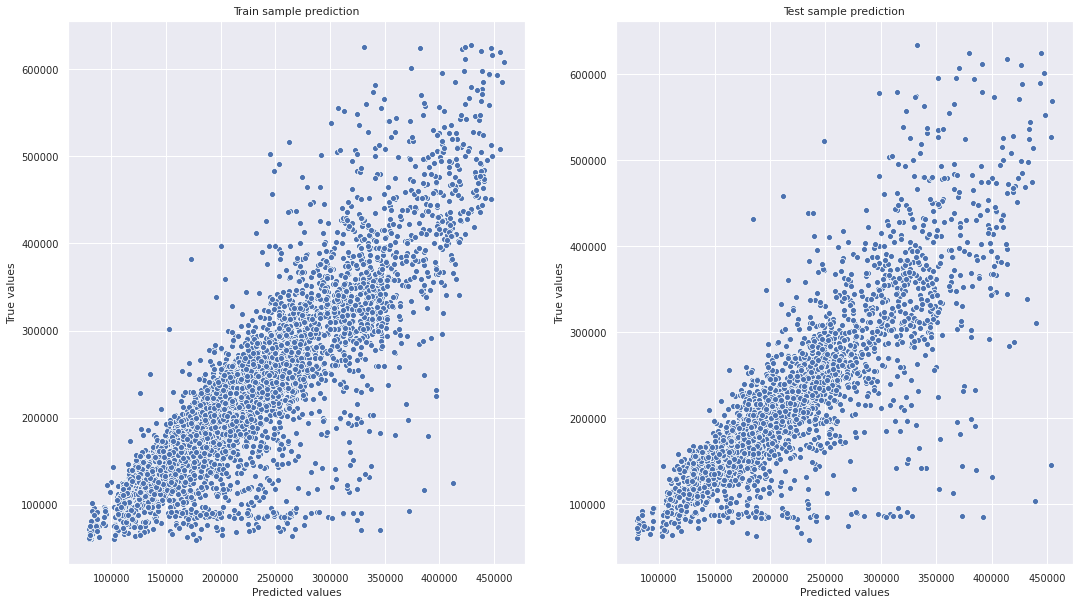

In [192]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

**GradientBoosting**

In [193]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=60,
                                     random_state=42,  
                                     n_estimators=800, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.025)

gb_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', learning_rate=0.025, loss='huber',
                          max_depth=7, max_features='sqrt', min_samples_leaf=60,
                          n_estimators=800, random_state=42)

Train R2:	0.853
Test R2:	0.738


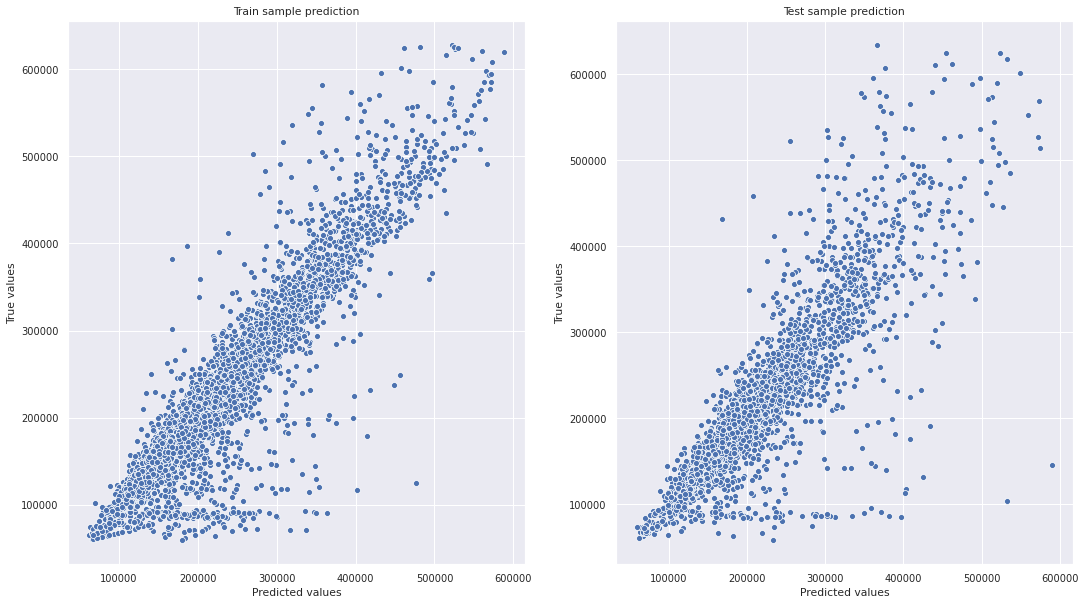

In [194]:
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

#### Кросс-валидация

**для линейной модели:**

In [195]:
cv_score = cross_val_score(lr_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=42))
cv_score

array([0.7589747 , 0.69001119, 0.72777908, 0.7087557 , 0.7281658 ])

In [196]:
cv_score.mean()

0.7227372932786376

**для RandomForest:**

In [197]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=42))
cv_score

array([0.73451866, 0.70458202, 0.6933868 , 0.71442538, 0.72444559])

In [198]:
cv_score.mean()

0.7142716907236564

**для GradientBoosting:**

In [199]:
cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=42))
cv_score

array([0.80090621, 0.74330939, 0.76059786, 0.77444149, 0.78901224])

In [200]:
cv_score.mean()

0.7736534379271554

**Важность признаков**

In [201]:
#для  модели градиентного бустинга
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
30,MedPriceByDistrict,0.194035
3,Square,0.134116
2,Rooms,0.075882
4,LifeSquare,0.070824
24,DistrictSize,0.063224
32,MedPriceBySquare,0.061802
33,MedPriceBySocial_1,0.059393
29,square_cat,0.054252
12,Social_1,0.037586
31,MedPriceByFloorYear,0.037126


**Ансамбль моделей**

In [203]:
from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor, GradientBoostingRegressor

rf = RandomForestRegressor(criterion='mse',
                                 max_depth=50,  
                                 min_samples_leaf=25, 
                                 max_features='log2',
                                 random_state=42, 
                                 n_estimators=500  
                                 )
gb = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=60,
                                     random_state=42,  
                                     n_estimators=800, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.025)
gb2 = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=60,
                                     random_state=42,  
                                     n_estimators=800, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.025)
stack = StackingRegressor([('rf', rf), ('gb', gb)], final_estimator=gb2)
stack.fit(X_train, y_train)

StackingRegressor(estimators=[('rf',
                               RandomForestRegressor(max_depth=50,
                                                     max_features='log2',
                                                     min_samples_leaf=25,
                                                     n_estimators=500,
                                                     random_state=42)),
                              ('gb',
                               GradientBoostingRegressor(criterion='mse',
                                                         learning_rate=0.025,
                                                         loss='huber',
                                                         max_depth=7,
                                                         max_features='sqrt',
                                                         min_samples_leaf=60,
                                                         n_estimators=800,
                                            

Train R2:	0.849
Test R2:	0.732


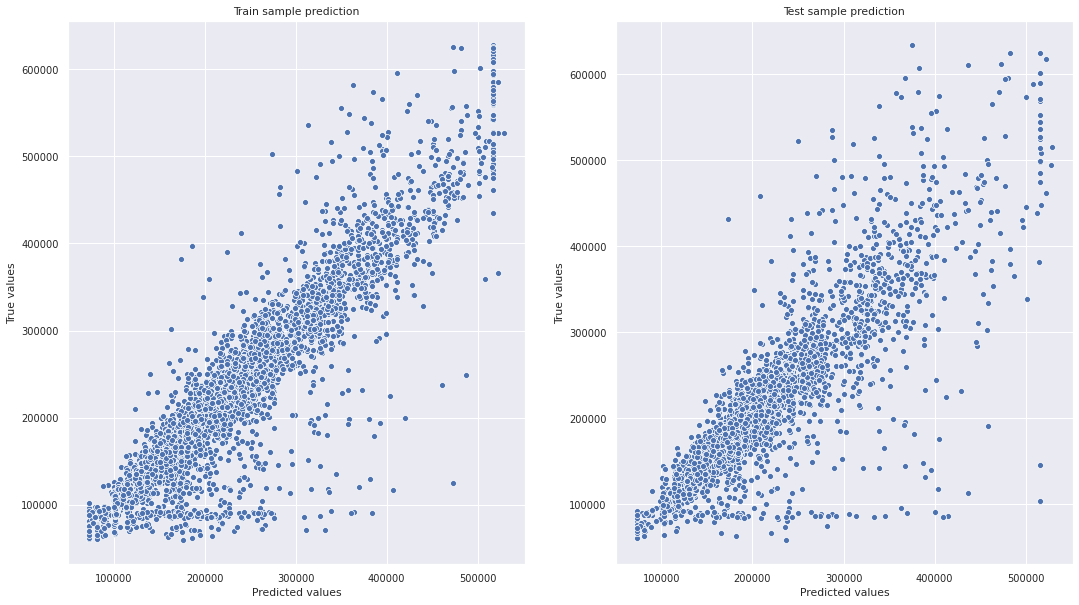

In [204]:
y_train_preds = stack.predict(X_train)
y_test_preds = stack.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

### Прогнозирование на тестовом датасете

In [205]:
test_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,IsDistrictLarge,floor_cat,year_cat,square_cat,MedPriceByDistrict,MedPriceByFloorYear,MedPriceBySquare,MedPriceBySocial_1,MedPriceByHelthcare_2,MedPriceByShops_1
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,...,0,1.0,3.0,0.0,171145.169069,183817.821818,158785.53125,210944.109375,216133.46875,188768.312500
1,5925,62,1.0,42.493907,22.493907,10.0,7,17.0,2017,0.072158,...,0,2.0,6.0,1.0,130974.239681,180889.662845,183733.50000,161357.593750,169383.06250,161573.046875
2,960,27,2.0,59.463678,40.463678,9.0,19,19.0,1977,0.211401,...,1,4.0,3.0,1.0,166311.346824,166576.120102,183733.50000,129512.695312,169383.06250,188768.312500
3,3848,23,3.0,49.646030,33.646030,6.0,2,2.0,1965,0.014073,...,1,0.0,3.0,1.0,172778.615365,176869.369854,183733.50000,161357.593750,169383.06250,161573.046875
4,746,74,1.0,53.837056,37.837056,6.0,8,17.0,1977,0.309479,...,0,2.0,3.0,1.0,164116.183543,190325.071232,183733.50000,201174.718750,169383.06250,215409.890625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2.0,43.177521,28.177521,5.0,4,5.0,1962,0.069660,...,0,1.0,3.0,1.0,183575.963167,183817.821818,183733.50000,199227.687500,216133.46875,182814.218750
4996,16138,38,3.0,93.698122,73.698122,10.0,21,27.0,2018,0.060753,...,0,4.0,6.0,3.0,425037.641820,206168.319222,297390.68750,258092.875000,169383.06250,237350.875000
4997,3912,101,1.0,33.656723,18.656723,5.0,2,5.0,1966,0.038693,...,0,0.0,3.0,0.0,156266.487610,176869.369854,158785.53125,191131.281250,198882.37500,198652.250000
4998,5722,10,1.0,38.635155,19.635155,9.0,8,14.0,1970,0.089040,...,0,2.0,3.0,0.0,185704.766694,190325.071232,158785.53125,219892.968750,169383.06250,251464.953125


In [206]:
test_df.shape

(5000, 36)

In [207]:
submit = pd.read_csv('/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [208]:
predictions = stack.predict(test_df)
predictions

array([167459.04147743, 122719.27695764, 136024.69263843, ...,
       150571.84048884, 187587.96153696, 292217.33350803])

In [209]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,167459.041477
1,5925,122719.276958
2,960,136024.692638
3,3848,107978.890050
4,746,189643.189555


In [210]:
submit.to_csv('dds_submit.csv', index=False)